# Walkability in Bristol
While [walkscores](https://www.walkscore.com/) exist, these services are paid and do not necessarily relate to insurance target variables.

In the notebook below I calculate the average walking distance (from all ) to the nearest 1,2,...,10 nearest common leisure points of interest (POI) in towns, like Eastbourne.
The selected POIs were arbitrarily selected, and these can be adapted given some requirements.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import osmnx as ox
import pandana
import h3pandas
import contextily as ctx

In [2]:
cityname = "Eastbourne, United Kingdom"
crs = 27700

In [3]:
# Get osmn walking graph
graph = ox.graph_from_place(cityname, network_type="walk")
# to bng
graph = ox.projection.project_graph(graph, to_crs=crs)

In [4]:
# Select pois
tags = {
    "amenity":[
        "cafe",
        "bar",
        "pub",
        "restaurant"
    ],
    "shop":[
        "bakery",
        "convenience",
        "supermarket",
        "mall",
        "department_store",
        "clothes",
        "fashion",
        "shoes"
    ],
    "leisure":[
        "fitness_centre"
    ]
}

In [5]:
# Get amentities from place
pois = ox.geometries.geometries_from_place(cityname, tags=tags).to_crs(crs)

/tmp/ipykernel_8281/2660927735.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries.geometries_from_place(cityname, tags=tags).to_crs(crs)


In [6]:
max_walk_time = 15
# Walking speed
walk_speed = 4.5
# Convert mins to secs
max_walk_time_secs = max_walk_time * 60

In [7]:
# Apply walking speed to all edges
for u, v, data in graph.edges(data=True):
    data["speed_kph"] = max_walk_time_secs
graph = ox.add_edge_travel_times(graph)

In [8]:
nodes = ox.graph_to_gdfs(graph, edges=False)[["x", "y"]]
edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[["u", "v", "travel_time"]]

In [9]:
# Construct pandana network
network = pandana.Network(
    node_x=nodes["x"],
    node_y=nodes["y"], 
    edge_from=edges["u"],
    edge_to=edges["v"],
    edge_weights=edges[["travel_time"]]
)

Generating contraction hierarchies with 2 threads.
Setting CH node vector of size 6628
Setting CH edge vector of size 17558
Range graph removed 17830 edges of 35116
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [10]:
# Set the pois" locations on the network
cen = pois.centroid
network.set_pois(
    category="pois",
    maxdist=max_walk_time_secs,
    maxitems=10,
    x_col=cen.x, 
    y_col=cen.y
)


In [11]:
n_pois = 5

In [12]:
# calculate travel time to 10 nearest pois from each node in network
distances = network.nearest_pois(
    distance=max_walk_time_secs,
    category="pois",
    num_pois=n_pois,
)
distances.astype(int).head()

1  2  3  4  5
osmid                    
540105      1  1  2  2  2
2469327920  1  1  2  2  2
243880375   1  2  2  2  2
9997144     1  1  2  2  2
540109      1  2  2  2  2

In [13]:
walking_df = pd.concat([nodes, distances], axis=1)
walking_gdf = gpd.GeoDataFrame(
    data=walking_df,
    geometry=gpd.points_from_xy(x=walking_df["x"], y=walking_df["y"]),
    crs=crs,
).to_crs(4326)
walking_gdf["lng"] = walking_gdf.geometry.x
walking_gdf["lat"] = walking_gdf.geometry.y
walking_df = walking_gdf.drop(["x", "y", "geometry"], axis=1)
walking_df.head()

1      2      3      4      5       lng        lat
osmid                                                             
540105      1.508  1.803  2.003  2.005  2.305  0.288726  50.794166
2469327920  1.507  1.802  2.002  2.004  2.304  0.288700  50.794204
243880375   1.808  2.103  2.303  2.305  2.605  0.289696  50.793759
9997144     1.608  1.903  2.103  2.105  2.405  0.288668  50.793895
540109      1.707  2.002  2.202  2.204  2.504  0.288417  50.793794

However, observing any pattern from 30,000 points is almost impossible to the naked eye: let's aggregate (mean) these points using a consistent surface (Uber H3).

In [14]:
walking_df.shape

(6628, 7)

In [15]:
res = 9
h3_col = f"h3_0{res}"

In [16]:
walking_df_h3 = walking_df.h3.geo_to_h3(res).drop(["lat", "lng"], axis=1)
walking_df_h3.shape

(6628, 5)

In [17]:
walking_df_h3 = walking_df_h3.groupby(by=h3_col).mean()
walking_df_h3.shape

(389, 5)

In [18]:
walking_df_h3_geo = (
    walking_df_h3.h3
    .h3_to_geo_boundary()
    .reset_index(drop=False)
    .to_crs(crs)
)
walking_df_h3_geo.columns

Index(['h3_09', 1, 2, 3, 4, 5, 'geometry'], dtype='object')

In [19]:
poi_cols = []
for i in range(1, n_pois+1):
    poi_cols.append(str(i))
poi_cols

['1', '2', '3', '4', '5']

In [20]:
cols = [h3_col] + poi_cols + ["geometry"]
walking_df_h3_geo.columns = cols

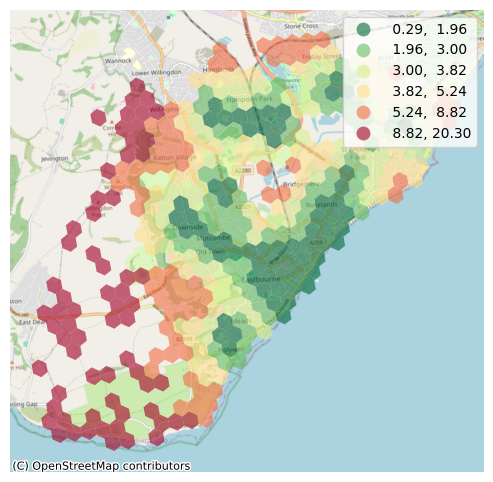

In [21]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
walking_df_h3_geo[["geometry", "5"]].plot(
    ax=ax,
    column=poi_cols[-1],
    scheme="quantiles",
    k=6,
    cmap="RdYlGn_r",
    alpha=0.6,
    legend=True,
)
ctx.add_basemap(
    ax,
    crs=walking_df_h3_geo.crs.to_string(),
    source=ctx.providers.OpenStreetMap.Mapnik,
)
ax.set_axis_off()

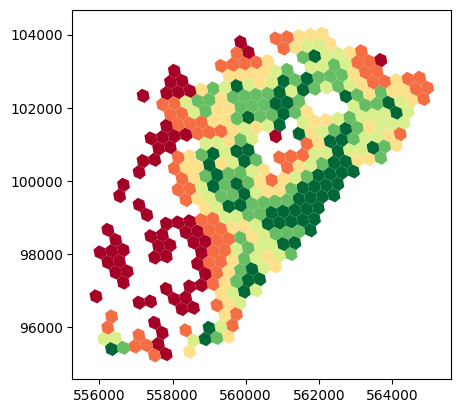

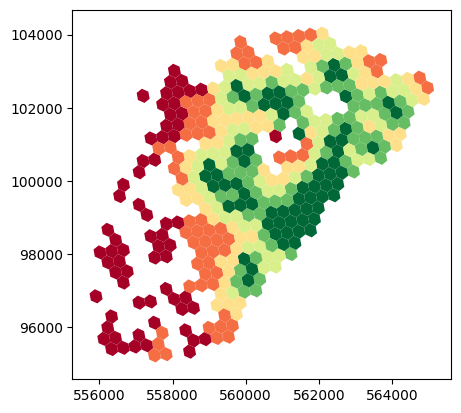

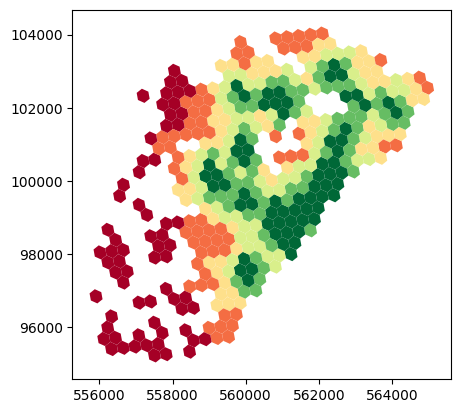

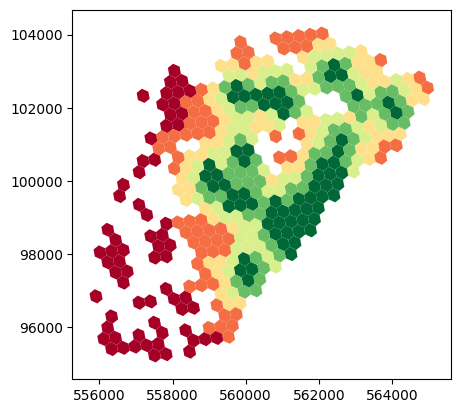

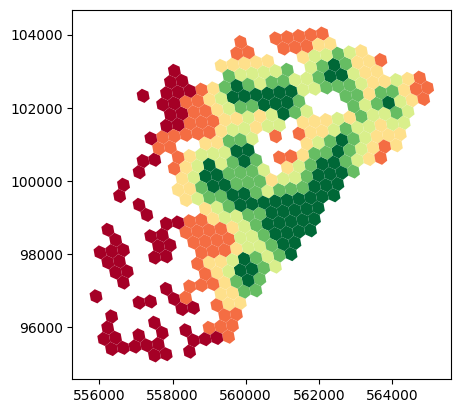

In [22]:
for i in poi_cols:
    walking_df_h3_geo.plot(
        column=i,
        k=6,
        scheme="quantiles",
        cmap="RdYlGn_r",
    )
    